In [1]:
import pandas as pd
from pathlib import Path
from lagom.utils import pickle_load
import matplotlib.pyplot as plt


def load_loggings(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    out = []
    for seed_folder in p.iterdir():
        if seed_folder.is_dir() and (seed_folder/f).exists():
            out.append(pickle_load(seed_folder/f))
    return out


def get_items(loggings, key):
    out = []
    for logging in loggings:
        items = [x[key][0] for x in logging]
        out.append(items)
    return out


def get_xy(loggings, x_key, y_key):
    x = get_items(loggings, x_key)
    y = get_items(loggings, y_key)
    return x, y

In [2]:
log_folder = Path(f'logs/env.clip_action/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
configs

,ID,cuda,log.dir,log.interval,env.standardize,env.time_aware_obs,nn.recurrent,nn.sizes,nn.independent_V,agent.lr,...,agent.terminal_value_coef,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.N,train.ratio_T,env.id,env.clip_action
0,0,True,logs/env.clip_action,10,True,False,False,"[64, 64]",False,0.0007,...,None,0.5,exp,None,None,1000000.0,1,1.0,HalfCheetah-v2,True
1,1,True,logs/env.clip_action,10,True,False,False,"[64, 64]",False,0.0007,...,None,0.5,exp,None,None,1000000.0,1,1.0,HalfCheetah-v2,False
2,2,True,logs/env.clip_action,10,True,False,False,"[64, 64]",False,0.0007,...,None,0.5,exp,None,None,1000000.0,1,1.0,Hopper-v2,True
3,3,True,logs/env.clip_action,10,True,False,False,"[64, 64]",False,0.0007,...,None,0.5,exp,None,None,1000000.0,1,1.0,Hopper-v2,False


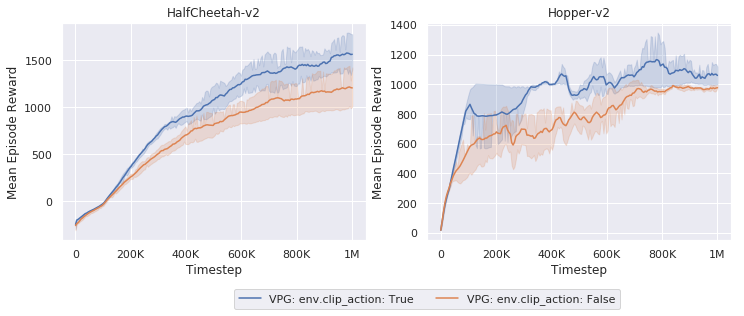

In [6]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 2, figsize=[2*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'env.clip_action'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'VPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'VPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   

legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')